### This notebook is in mypycaret environment to test the models for BigG_express data using the data merged df that were craeted in the previous notebook

In [144]:
#Libraries need for work

import pandas as pd
from datetime import datetime, timedelta



from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#we need to create a conda environment for pycaret and then pip install the packages after activating and rerun the notebook.
from pycaret.classification import *
from pycaret.regression import *
from pycaret.time_series import *

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [145]:
faults_clean = pd.read_csv("../data/faults_clean.csv")

In [146]:
derate_feature = pd.read_pickle('../data/derate_features.pk')

In [147]:
derate_target = pd.read_pickle('../data/derate_target.pk')

In [148]:
derate_target.shape #(546674, 2)

(546674, 2)

In [149]:
derate_feature.shape #(546674, 461)

(546674, 461)

In [150]:
derate_feature.info()
derate_feature.columns.to_series().groupby(derate_feature.dtypes).groups

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546674 entries, 536775 to 70148
Columns: 461 entries, RecordID to target
dtypes: bool(1), datetime64[ns](2), float64(419), int32(1), int64(6), object(32)
memory usage: 1.9+ GB


{bool: ['active'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi'], float64: ['Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213', 'spn_1231', 'spn_1235', 'spn_1236', 'spn_1239', 'spn_1247', 'spn_125', 'spn_127', 'spn_1279', 'spn_1321', 'spn_1322', 'spn_1323', 'spn_1324', 'spn_1325', 'spn_1326', 'spn_1327', 'spn_1328', 'spn_1347', 'spn_1349', 'spn_13600', 'spn_139296', 'spn_1464', 'spn_1481', 'spn_1482', 'spn_1483', 'spn_1487', 'spn_153', 'spn_153931', 'spn_1569', 'spn_157', 'spn_158', 'spn_16', 'spn_160', 'spn_1612', 'spn_1659', 'spn_1668', 'spn_167', 'spn_1675', 'spn_168', 'spn_17096', 'spn_171', 'spn_173', 'spn_174', 'spn_175', 'spn

In [151]:
derate_feature['MCTNumber'].isna().sum()

0

In [152]:
# derate_feature.columns.to_list()


In [153]:
#how to find a column where a particula string exists
# word = 'Low (Severity Low) Engine Coolant Level' #this string is causing problem which is present in event description so going to drop that column as well
word = 'unknown'
derate_feature.columns[derate_feature[derate_feature==word].notna().sum()>0][0]

'ecuSoftwareVersion'

In [154]:
# X = derate_feature.drop(columns=['EquipmentID_y', 'eventDescription', 'ecuSoftwareVersion', 'active',
#                                  'ecuModel', 'ecuMake', 'activeTransitionCount', 'EquipmentID_x',
#                                  'MCTNumber', 'SPN_FMI', 'EquipmentID_y', 'spn_fmi','EventTimeStamp',
# 'Latitude',
#  'Longitude',
#  'LocationTimeStamp',
#  'SPN_FMI',
#  'target'])

X= derate_feature[['AcceleratorPedal', 'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature', 
                'LampStatus', 'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure',]]
y = derate_feature[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

# linreg_base = LinearRegression().fit(X_train_sm1, y_train_sm1)# 

# X_train_added2.columns
# X_train_added2.head(10)

In [155]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(410005, 21)
(136669, 21)
(136669, 1)


In [156]:
from sklearn.impute import SimpleImputer
logReg_scaler = Pipeline(
    steps = [
        ('impute', SimpleImputer()), #fills average of the column if there are NaN missing values
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C = 0.01)) #started from 0.01, 0,001, 
    ]
).fit(X_train, y_train)

In [157]:
# fit the model on X_test data
logreg1 = logReg_scaler.predict(X_test)

In [158]:
#finding the accuracy score

accuracy_score(y_test, logreg1)

0.9971902918730656

In [159]:
pd.DataFrame({'feature': logReg_scaler['impute'].get_feature_names_out(),
                             'coefficient': logReg_scaler['log_reg'].coef_[0],
             "ex_coefficient": np.exp(logReg_scaler['log_reg'].coef_[0])}).sort_values(by='coefficient')
#every drop in the x-feature affects the predicted probability by the ex_coefficient

,feature,coefficient,ex_coefficient
8,EngineRpm,-0.395508,0.673338
1,BarometricPressure,-0.283382,0.753232
6,EngineOilPressure,-0.242197,0.784902
14,IntakeManifoldTemperature,-0.165102,0.847807
11,FuelLtd,-0.075440,0.927336
10,FuelLevel,-0.055616,0.945902
4,EngineCoolantTemperature,-0.033965,0.966606
0,AcceleratorPedal,-0.018691,0.981482
7,EngineOilTemperature,-0.010503,0.989552
17,Speed,-0.009411,0.990633


In [161]:
confusion_matrix(y_test, logReg_scaler.predict(X_test))

array([[136285,      2],
       [   382,      0]], dtype=int64)

In [162]:
from cm import plot_confusion_matrix #cm is function writen by Michael

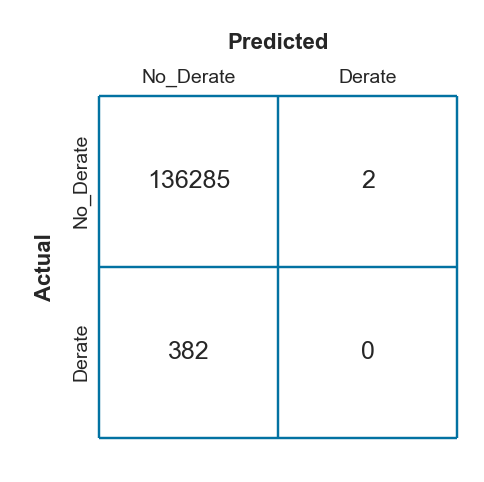

In [163]:
plot_confusion_matrix(y_test, logReg_scaler.predict(X_test), labels = ['No_Derate', 'Derate']);

In [160]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

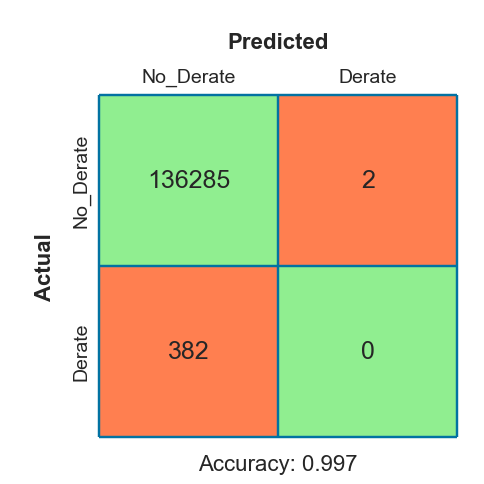

In [189]:
plot_confusion_matrix(y_test, logReg_scaler.predict(X_test), labels = ['No_Derate', 'Derate'], metric = 'accuracy');

In [164]:
from sklearn.metrics import roc_auc_score

In [165]:
roc_auc_score(y_test, logReg_scaler.predict_proba(X_test)[:,1] )

0.8525730675299205

In [169]:
derate_feature['EquipmentID_x'].nunique() #1042
derate_feature.loc[derate_feature['target']==1]['EquipmentID_x'].nunique() #189

#list of the all trucks EquipentID where derate happened
derate_trucks = derate_feature.loc[derate_feature['target']==1]['EquipmentID_x'].unique()

#list of the all trucks EquipentID in faults table
all_trucks = derate_feature['EquipmentID_x'].unique()

#list of the all trucks EquipentID which did not have any derate
no_derate = all_trucks[np.isin(all_trucks, derate_trucks, invert=True)]

len(no_derate) #853
# derate_feature.loc[derate_feature['target']==0]['EquipmentID_x'].nunique()

853

In [167]:
174932+371742

546674

In [170]:
df_derate = derate_feature[(derate_feature['EquipmentID_x'].isin(derate_trucks))]
df_derate.shape #(174932, 461)

(174932, 461)

In [171]:
df_no = derate_feature[(derate_feature['EquipmentID_x'].isin(no_derate))] #371742 rows × 461 columns

In [173]:
df_derate

,RecordID,spn,fmi,AcceleratorPedal,BarometricPressure,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,...,spn_94,spn_940,spn_941,spn_95,spn_96,spn_97,spn_976,spn_98,spn_fmi,target
444126,1248431,96,3,0.0,14.645,66.48672,443434.9,186.8,12.0,22.62,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,96_3,0
444127,1248432,829,3,0.0,14.645,66.48672,443434.9,186.8,12.0,22.62,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,829_3,0
444128,1248425,829,3,0.0,14.645,66.48672,443434.3,185.0,17.0,22.04,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,829_3,0
444129,1248426,96,3,0.0,14.645,66.48672,443434.3,185.0,17.0,22.04,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,96_3,0
444130,1248394,96,3,0.0,14.645,66.48672,443424.0,185.0,12.0,24.94,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,96_3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157880,17,111,17,37.2,14.1375,66.48672,268575.9,183.2,26.0,33.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111_17,0
36118,62,111,17,57.6,14.4275,64.6226,470383.5,190.4,46.0,35.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111_17,0
126238,11,111,17,0.0,14.1375,64.6226,257885.9,181.4,80.0,34.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111_17,0
36119,6,111,17,48.0,14.4275,64.6226,470381.4,181.4,30.0,38.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111_17,0


In [174]:
#Now we will divide in train test trucks with derate or noderate with each truck(EquipmentID) either in train or test not both.

In [175]:
##Making the 80/20 split in the train/test among all the trucks with derate
X = df_derate.drop(columns=['target'])
y= df_derate[['target']]

X_train_derate, X_test_derate, y_train_derate, y_test_derate = train_test_split(X, y, train_size = 0.8,
                                                                                test_size = 0.2, 
                                                                                random_state = 321)

print(X_train_derate.shape)
print(X_test_derate.shape)
print(y_train_derate.shape)
print(y_test_derate.shape)

(139945, 460)
(34987, 460)
(139945, 1)
(34987, 1)


In [176]:
##Making the 80/20 split in the train/test among all the trucks with noderate

X_no = df_no.drop(columns=['target'])
y_no= df_no[['target']]

X_train_noderate, X_test_noderate, y_train_noderate, y_test_noderate = train_test_split(X_no, y_no, train_size = 0.8,
                                                                                test_size = 0.2, 
                                                                                random_state = 321)

print(X_train_noderate.shape)
print(X_test_noderate.shape)
print(y_train_noderate.shape)
print(y_test_noderate.shape)

(297393, 460)
(74349, 460)
(297393, 1)
(74349, 1)


In [132]:
## Putting the derate_train and non_derate_train together like wise doing that with the test
# df = all_trucks[~all_trucks[['EquipmentID']].isin(derate_trucks).any(axis=1)]
# pd.concat([data1, data2], axis=0)

X_train1 = pd.concat([X_train_derate, X_train_noderate], axis=0) #437338 rows × 460 columns

X_test1 = pd.concat([X_test_derate, X_test_noderate], axis=0) #109336 rows × 460 columns

y_train1 = pd.concat([y_train_derate, y_train_noderate], axis=0) #437338 rows × 1 columns

y_test1 = pd.concat([y_test_derate, y_test_noderate], axis=0) #109336 rows × 1 columns

In [177]:
#cases take out due to 25% or more missing values
y_train1['target'].value_counts()

0    436221
1      1117
Name: target, dtype: int64

In [178]:
#cases take out due to 25% or more missing values
y_test1['target'].value_counts()

0    109064
1       272
Name: target, dtype: int64

In [179]:
X_train1.info()
X_train1.columns.to_series().groupby(X_train1.dtypes).groups

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437338 entries, 170963 to 212282
Columns: 460 entries, RecordID to spn_fmi
dtypes: bool(1), datetime64[ns](2), float64(419), int64(6), object(32)
memory usage: 1.5+ GB


{bool: ['active'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi'], float64: ['Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213', 'spn_1231', 'spn_1235', 'spn_1236', 'spn_1239', 'spn_1247', 'spn_125', 'spn_127', 'spn_1279', 'spn_1321', 'spn_1322', 'spn_1323', 'spn_1324', 'spn_1325', 'spn_1326', 'spn_1327', 'spn_1328', 'spn_1347', 'spn_1349', 'spn_13600', 'spn_139296', 'spn_1464', 'spn_1481', 'spn_1482', 'spn_1483', 'spn_1487', 'spn_153', 'spn_153931', 'spn_1569', 'spn_157', 'spn_158', 'spn_16', 'spn_160', 'spn_1612', 'spn_1659', 'spn_1668', 'spn_167', 'spn_1675', 'spn_168', 'spn_17096', 'spn_171', 'spn_173', 'spn_174', 'spn_175', 'spn

In [194]:
chosen_cl = ['RecordID', 'spn', 'fmi', 'AcceleratorPedal', 'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd', 
 'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm', 
 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature',
 'LampStatus', 'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure',
  'spn_fmi'
]

In [180]:
X_train_derate.columns.to_series().groupby(X_train_derate.dtypes).groups

{bool: ['active'], int64: ['RecordID', 'spn', 'fmi', 'ecuSource', 'spn', 'fmi'], float64: ['Latitude', 'Longitude', 'spn_0', 'spn_100', 'spn_101', 'spn_102', 'spn_1023', 'spn_1024', 'spn_1028', 'spn_103', 'spn_1043', 'spn_1045', 'spn_105', 'spn_1056', 'spn_1059', 'spn_1067', 'spn_1068', 'spn_107', 'spn_1071', 'spn_1072', 'spn_1075', 'spn_1078', 'spn_108', 'spn_1081', 'spn_110', 'spn_111', 'spn_1127', 'spn_114863', 'spn_116', 'spn_1172', 'spn_1176', 'spn_118', 'spn_1209', 'spn_1213', 'spn_1231', 'spn_1235', 'spn_1236', 'spn_1239', 'spn_1247', 'spn_125', 'spn_127', 'spn_1279', 'spn_1321', 'spn_1322', 'spn_1323', 'spn_1324', 'spn_1325', 'spn_1326', 'spn_1327', 'spn_1328', 'spn_1347', 'spn_1349', 'spn_13600', 'spn_139296', 'spn_1464', 'spn_1481', 'spn_1482', 'spn_1483', 'spn_1487', 'spn_153', 'spn_153931', 'spn_1569', 'spn_157', 'spn_158', 'spn_16', 'spn_160', 'spn_1612', 'spn_1659', 'spn_1668', 'spn_167', 'spn_1675', 'spn_168', 'spn_17096', 'spn_171', 'spn_173', 'spn_174', 'spn_175', 'spn

In [195]:
X_train1_short = X_train1[chosen_cl]
X_train1_short.shape #(437338, 28)

(437338, 27)

In [196]:
X_test1_short = X_test1[chosen_cl]
X_test1_short.shape #(109336, 28)

(109336, 27)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from imblearn.over_sampling import SMOTE
oversampler = SMOTE(k_neighbors=5, random_state=42)
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)
y_smote.value_counts()
gbr_smoted = Pipeline(
    steps = [
        ('gb', GradientBoostingClassifier(verbose=True))#n_estimators = 1000, learning_rate=0.01
    ]
)

gbr_smoted.fit(X_smote, y_smote)
y_predict = gbr_smoted.predict(X_train)
confusion_matrix(y_train, y_predict)
confusion_matrix(y_test, gbr.predict(X_test))
confusion_matrix(y_test, gbr_smoted.predict(X_test))
print(classification_report(y_train, y_predict))

#### Running the above logReg_sclaer pipeline with the equipment clustered train test split data
1. X_train1_short
2. X_test1_short
3. y_train1
4. y_test1

In [192]:
y_train1.head()

,target
170963,0
423364,0
419070,0
368390,0
114639,0


In [221]:
#from sklearn.impute import SimpleImputer
#step1
logReg_scaler = Pipeline(
    steps = [
        ('impute', SimpleImputer()), #fills average of the column if there are NaN missing values
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C = 0.01)) #started from 0.01, 0,001, 
    ]
).fit(X_train1_short, y_train1['target'])

In [222]:
#step2
logreg1 = logReg_scaler.predict(X_test1_short)

In [223]:
#step3
accuracy_score(y_test1['target'], logreg1) #0.9974939635618644(c=0.01), 0.997484817443477(0.001)

0.9974939635618644

In [208]:
#step4 ROC_AUC 
roc_auc_score(y_test1['target'], logReg_scaler.predict_proba(X_test1_short)[:,1] )

0.8308154736991987

In [209]:
#step5
#extracting the features
pd.DataFrame({'feature': logReg_scaler['impute'].get_feature_names_out(),
                             'coefficient': logReg_scaler['log_reg'].coef_[0],
             "ex_coefficient": np.exp(logReg_scaler['log_reg'].coef_[0])}).sort_values(by='coefficient')
#every drop in the x-feature affects the predicted probability by the ex_coefficient

,feature,coefficient,ex_coefficient
13,EngineRpm,-0.522999,0.592740
6,BarometricPressure,-0.340799,0.711202
11,EngineOilPressure,-0.332666,0.717010
19,IntakeManifoldTemperature,-0.115845,0.890614
26,spn_fmi,-0.104665,0.900626
9,EngineCoolantTemperature,-0.092996,0.911197
24,Throttle,-0.074923,0.927815
16,FuelLtd,-0.072049,0.930486
15,FuelLevel,-0.061007,0.940817
22,Speed,-0.007758,0.992272


In [211]:
#step6 confusion matrix
confusion_matrix(y_test1['target'], logReg_scaler.predict(X_test1_short))

array([[109062,      2],
       [   272,      0]], dtype=int64)

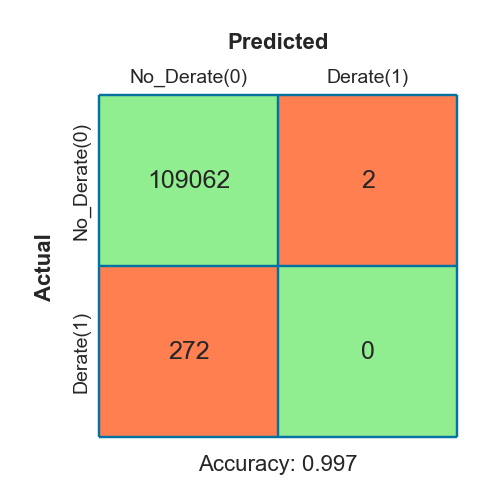

In [240]:
##step7 plotting matrix
plot_confusion_matrix(y_test1['target'], logReg_scaler.predict(X_test1_short), labels = ['No_Derate(0)', 'Derate'], metric = 'accuracy');

### using the fixed train test split improved slightly and False Negative reduced reduced from 382 to 272.
#### using OneHotEncoder on spn_fmi

In [253]:
?OneHotEncoder

In [292]:
#from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#step1
logReg_scaler_ohe = Pipeline(
    steps = [
        ('ct', ColumnTransformer(
            transformers = [
                ('ohe', OneHotEncoder(sparse=False, 
                                     handle_unknown="ignore"), ['spn_fmi'])], remainder='passthrough')),
                                                                      
        ('impute', SimpleImputer()), #fills average of the column if there are NaN missing values
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C = 0.01)) #started from 0.01, 0,001, 
    ]
).fit(X_train1_short, y_train1['target'])

MemoryError: 

In [286]:
ohe = logReg_scaler_ohe.predict(X_test1_short)

In [287]:
accuracy_score(y_test1['target'], ohe)

0.9985274749396357

In [288]:
confusion_matrix(y_test1['target'], logReg_scaler_ohe.predict(X_test1_short))

array([[109060,      4],
       [   157,    115]], dtype=int64)

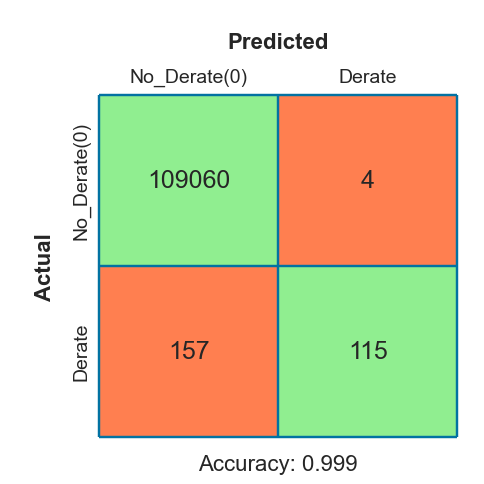

In [289]:
##step7 plotting matrix
plot_confusion_matrix(y_test1['target'], logReg_scaler_ohe.predict(X_test1_short), labels = ['No_Derate(0)', 'Derate'], metric = 'accuracy');

In [290]:
#step5
#extracting the features
pd.DataFrame({'feature': logReg_scaler_ohe['ct'].get_feature_names_out(),
                             'coefficient': logReg_scaler_ohe['log_reg'].coef_[0],
             "ex_coefficient": np.exp(logReg_scaler_ohe['log_reg'].coef_[0])}).sort_values(by='coefficient')
#every drop in the x-feature affects the predicted probability by the ex_coefficient

,feature,coefficient,ex_coefficient
919,ohe__spn_fmi_929_9,-0.251312,0.777780
893,ohe__spn_fmi_829_3,-0.099789,0.905028
947,ohe__spn_fmi_97_15,-0.089091,0.914762
949,ohe__spn_fmi_97_3,-0.063578,0.938401
559,ohe__spn_fmi_51923_0,-0.058184,0.943476
...,...,...,...
586,ohe__spn_fmi_5246_16,0.163377,1.177481
188,ohe__spn_fmi_1761_19,0.164688,1.179025
50,ohe__spn_fmi_1068_2,0.190217,1.209511
583,ohe__spn_fmi_5246_0,0.328008,1.388201


In [229]:
X_train_derate.shape #
(139945, 460)

(139945, 460)

In [231]:
((X_train_derate['EventTimeStamp'].max())-X_train_derate['EventTimeStamp'].min()) #the entire data spans over 1840 days

Timedelta('1840 days 18:29:05')

<Axes: xlabel='EquipmentID_x'>

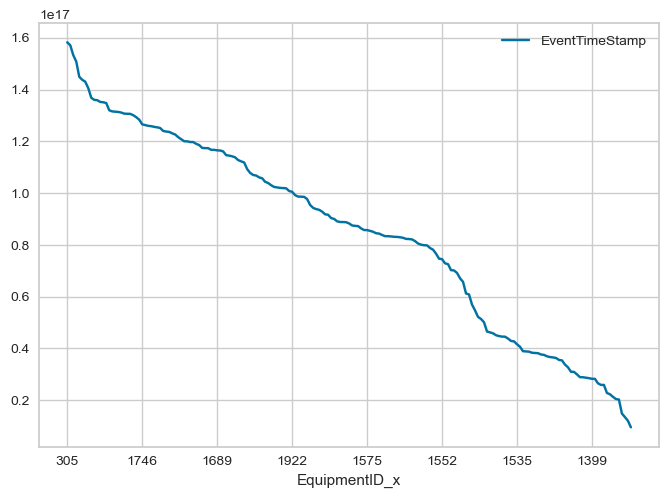

In [279]:
((X_train_derate.groupby('EquipmentID_x')['EventTimeStamp'].max())-
 (X_train_derate.groupby('EquipmentID_x')['EventTimeStamp'].min())).to_frame().sort_values('EventTimeStamp',
                                                                                           ascending=False).plot()

TypeError: The DType <class 'numpy.dtype[float64]'> could not be promoted by <class 'numpy.dtype[timedelta64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[timedelta64]'>)

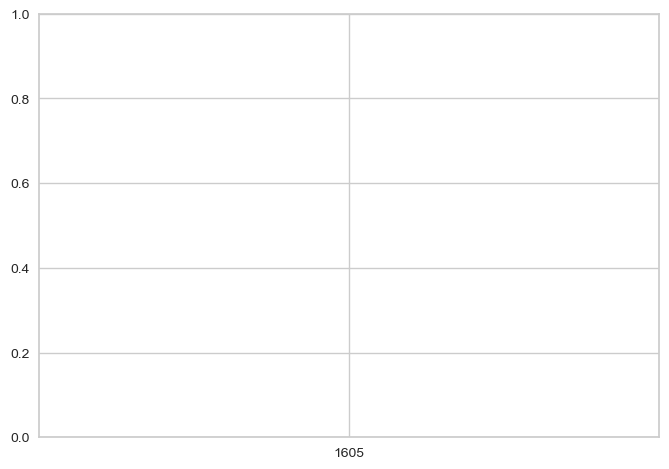

In [246]:
# size and color:
sizes = np.random.uniform(15, 80, len(x))
colors = np.random.uniform(15, 80, len(x))

y = ((X_train_derate.groupby('EquipmentID_x')['EventTimeStamp'].max())-
 (X_train_derate.groupby('EquipmentID_x')['EventTimeStamp'].min()))
x = X_train_derate['EquipmentID_x'].unique()

# plot
fig, ax = plt.subplots()

ax.scatter(x, y, s=sizes, c=colors, vmin=0, vmax=100)

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()